# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [3]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [4]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 11066 / 11441 MB available


In [30]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    // Pseudocode
    // c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j * cols + i;
    
    c[k] = a[k] + b[k];
}

// To be implemented a function matrixVectorKernel
__global__ void matrixVectorKernel(float* c, float* a, float* b, int a_columns) {
    // unsigned int i = blockIdx.x*blockDim.x + threadIdx.x
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    float sum = 0.0f;
    
    for(int i = 0; i <= a_columns; ++i) {    
        unsigned int k = j * a_columns + i;
        sum += a[k] * b[i];
    }
    
    c[j] = sum;

}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");



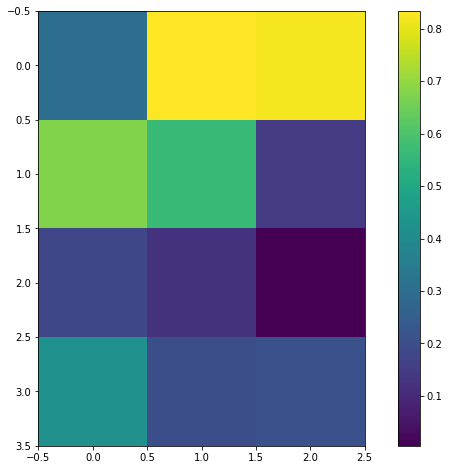

In [31]:
#Size of our test
a_size = (4, 3)
b_size = (3, 1)
c_size = (4, 1)

#Create test input / output data
a = np.random.random(a_size).astype(np.float32)
b = np.random.random(b_size).astype(np.float32)
c = np.empty_like(c.size).astype(np.float32)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()

In [32]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [33]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [34]:
#a.shape = [rows, columns] => [y, x]
#Block size and grid size should be so that the number of threads is equal to the number of rows of matrix A
domain_size = (a.shape[1], a.shape[0])
block_size = (1, 1, 1)#a.shape[0], 1)#these need to be [x, y, z]
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (3, 4)
Block size is (1, 1, 1)
Grid size is (3, 4, 1)


In [35]:
#Execute program on device 
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host 
c_g.get(c)

array(1.6640451, dtype=float32)

#Execute program on device 
kernel(c_g, a_g, b_g, np.int32(domain_size[1]) dblock=block_size, grid=grid_size)

#Copy data from device to host 
c_g.get(c)

#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[1])), dblock=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

In [38]:
#Compute reference using Numpy
#c_ref = a * b

#Print result
print("C   = ", c)
#print("Ref = ", c_ref)
#print("Sad = ", np.sum(np.abs(c - c_ref)))

ValueError: operands could not be broadcast together with shapes (4,3) (3,1) 

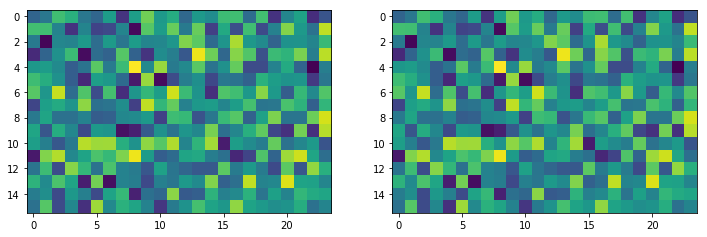

In [61]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(c)
plt.subplot(1, 2, 2)
plt.imshow(c_ref)